In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import warnings
import pickle
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from IPython.display import Image

In [2]:
DATASET_PATH = 'C:/Users/ASUS/Desktop/Учеба/Библиотеки Python для Data Science/Estate_project_training/train.csv'
PREPARED_DATASET_PATH = 'C:/Users/ASUS/Desktop/Учеба/Библиотеки Python для Data Science/Estate_project_training/train_done.csv'
REPORTS_FILE_PATH = 'C:/Users/ASUS/Desktop/Учеба/Библиотеки Python для Data Science/Estate_project_training/reports/'
SCALER_FILE_PATH = 'C:/Users/ASUS/Desktop/Учеба/Библиотеки Python для Data Science/Estate_project_training/scaler.pkl'
MODEL_FILE_PATH = 'C:/Users/ASUS/Desktop/Учеба/Библиотеки Python для Data Science/Estate_project_training/model.pkl'

In [3]:
df = pd.read_csv(DATASET_PATH, sep=",")
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [4]:
df.shape

(10000, 20)

In [5]:
df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [6]:
df['HouseFloor'] = df['HouseFloor'].astype('int64')
df['Id'] = df['Id'].astype('str')
df['HouseFloor'].dtype, df['Id'].dtype

(dtype('int64'), dtype('O'))

In [7]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [8]:
df['Ecology_2'] = (df['Ecology_2'] == 'B').astype(int)
df['Ecology_2'].value_counts()

1    9903
0      97
Name: Ecology_2, dtype: int64

In [9]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [10]:
df['Ecology_3'] = (df['Ecology_3'] == 'B').astype(int)
df['Ecology_3'].value_counts()

1    9725
0     275
Name: Ecology_3, dtype: int64

In [11]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [12]:
df['Shops_2'] = (df['Shops_2'] == 'B').astype(int)
df['Shops_2'].value_counts()

1    9175
0     825
Name: Shops_2, dtype: int64

In [13]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [14]:
df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [15]:
median_hc = df['Healthcare_1'].median()
df['Healthcare_1'].fillna(median_hc, inplace=True)
df['Healthcare_1'].isna().sum()

0

In [16]:
median_ls = df['Square'] * 0.6
df['LifeSquare'].fillna(median_ls, inplace=True)
df['LifeSquare'].isna().sum()

0

In [17]:
median_dist = df['DistrictId'].median()
df['DistrictId'].where(~(df.DistrictId == 0), other=median_dist, inplace=True)
df['DistrictId'].round()

0        27
1        22
2         1
3         1
4        94
       ... 
9995     61
9996     27
9997    178
9998     21
9999     94
Name: DistrictId, Length: 10000, dtype: int64

In [18]:
median_rooms = df['Rooms'].median()
df['Rooms'].where(~(df.Rooms < 1), other=2, inplace=True)
df['Rooms'].where(~(df.Rooms > 5), other=median_rooms, inplace=True)
df['Rooms'].round()
df['Rooms'] = df['Rooms'].astype('int64')
df['Rooms'].unique()

array([3, 1, 2, 4, 5], dtype=int64)

In [19]:
median_sq = df['Square'].median()
df['Square'].where(~(df.Square < 18), other=median_sq, inplace=True)
df['Square'].where(~(df.Square > 150), other=median_sq, inplace=True)
df['Square'].max(), df['Square'].min()

(148.67193849508902, 18.50917706919791)

In [20]:
median_ls = df['LifeSquare'].median()
df['LifeSquare'].where(~(df.LifeSquare > df.Square * 0.8), other=median_ls, inplace=True)
df['LifeSquare'].where(~(df.LifeSquare < 11), other=median_ls, inplace=True)
df['LifeSquare'].max(), df['LifeSquare'].min()

(100.20165202175312, 11.04760500283173)

In [21]:
median_ks = df['KitchenSquare'].median()
df['KitchenSquare'].where(~(df.KitchenSquare < 5), other=median_ks, inplace=True)
df['KitchenSquare'].where(~(df.KitchenSquare > 20), other=median_ks, inplace=True)

In [22]:
median_hf = df['HouseFloor'].median()
df['HouseFloor'].where(~(df.HouseFloor > 35), other=median_hf, inplace=True)

In [23]:
median_f = df['Floor'].median()
df['Floor'].where(~(df.HouseFloor < df.Floor), other=median_f, inplace=True)

In [24]:
median_hy = df['HouseYear'].median()
df['HouseYear'].where(~(df.HouseYear > 2020), other=median_hy, inplace=True)
df['HouseYear'].where(~(df.HouseYear < 1950), other=median_hy, inplace=True)

In [25]:
median_eco_1 = df['Ecology_1'].median()
df['Ecology_1'].where(~(df.Ecology_1 == 0), other=median_eco_1, inplace=True)

In [26]:
median_soc_1 = df['Social_1'].median()
df['Social_1'].where(~(df.Social_1 == 0), other=median_soc_1, inplace=True)

In [27]:
median_soc_2 = df['Social_2'].median()
df['Social_2'].where(~(df.Social_2 == 0), other=median_soc_2, inplace=True)

In [28]:
median_soc_3 = df['Social_3'].median()
df['Social_3'].where(~(df.Social_3 == 0), other=median_soc_3, inplace=True)

In [29]:
median_hc_1 = df['Healthcare_1'].median()
df['Healthcare_1'].where(~(df.Healthcare_1 == 0), other=median_hc_1, inplace=True)

In [30]:
median_hc_2 = df['Helthcare_2'].median()
df['Helthcare_2'].where(~(df.Helthcare_2 == 0), other=median_hc_2, inplace=True)

In [31]:
df.dtypes

Id                object
DistrictId         int64
Rooms              int64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor         int64
HouseYear          int64
Ecology_1        float64
Ecology_2          int32
Ecology_3          int32
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2            int32
Price            float64
dtype: object

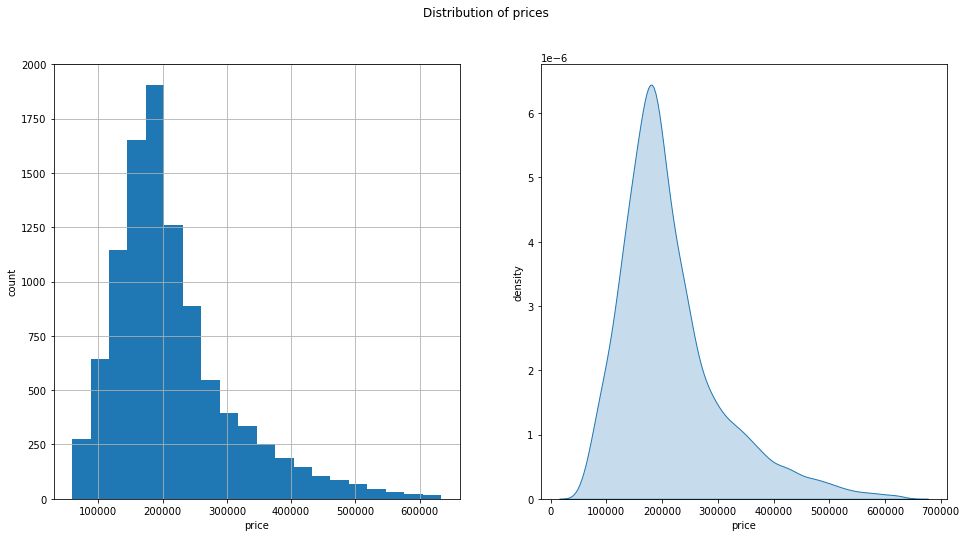

In [32]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('price')

plt.subplot(122)
sns.kdeplot(df['Price'], shade=True, legend=False)
plt.xlabel('price')
plt.ylabel('density')

plt.suptitle('Distribution of prices')
plt.show()

In [33]:
df_numbers = df.select_dtypes(include=['object', 'float64', 'int64', 'int32'])
df_numbers_new = df_numbers.drop(['Price'], axis=1)
df_numbers_new

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3,115.027311,69.016386,10.0,4,10,2014,0.075424,1,1,11,3097,2,900.0,1,0,1
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,1,1,33,5261,2,240.0,3,1,1
3,2352,1,1,40.409907,24.245944,6.0,10,22,1977,0.007122,1,1,1,264,2,900.0,1,1,1
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,1,1,33,8667,2,900.0,1,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2,49.090728,33.272626,6.0,3,12,1981,0.300323,1,1,52,10311,6,900.0,1,9,1
9996,16265,27,2,64.307684,37.038420,9.0,7,0,1977,0.072158,1,1,2,629,1,900.0,1,0,0
9997,2795,178,1,29.648057,16.555363,5.0,3,5,1958,0.460556,1,1,20,4386,14,900.0,1,5,1
9998,14561,21,1,32.330292,22.326870,5.0,3,9,1969,0.194489,1,1,47,8004,3,125.0,3,5,1


array([[<AxesSubplot:title={'center':'DistrictId'}>,
        <AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'LifeSquare'}>],
       [<AxesSubplot:title={'center':'KitchenSquare'}>,
        <AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>],
       [<AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Ecology_2'}>,
        <AxesSubplot:title={'center':'Ecology_3'}>,
        <AxesSubplot:title={'center':'Social_1'}>],
       [<AxesSubplot:title={'center':'Social_2'}>,
        <AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Helthcare_2'}>],
       [<AxesSubplot:title={'center':'Shops_1'}>,
        <AxesSubplot:title={'center':'Shops_2'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

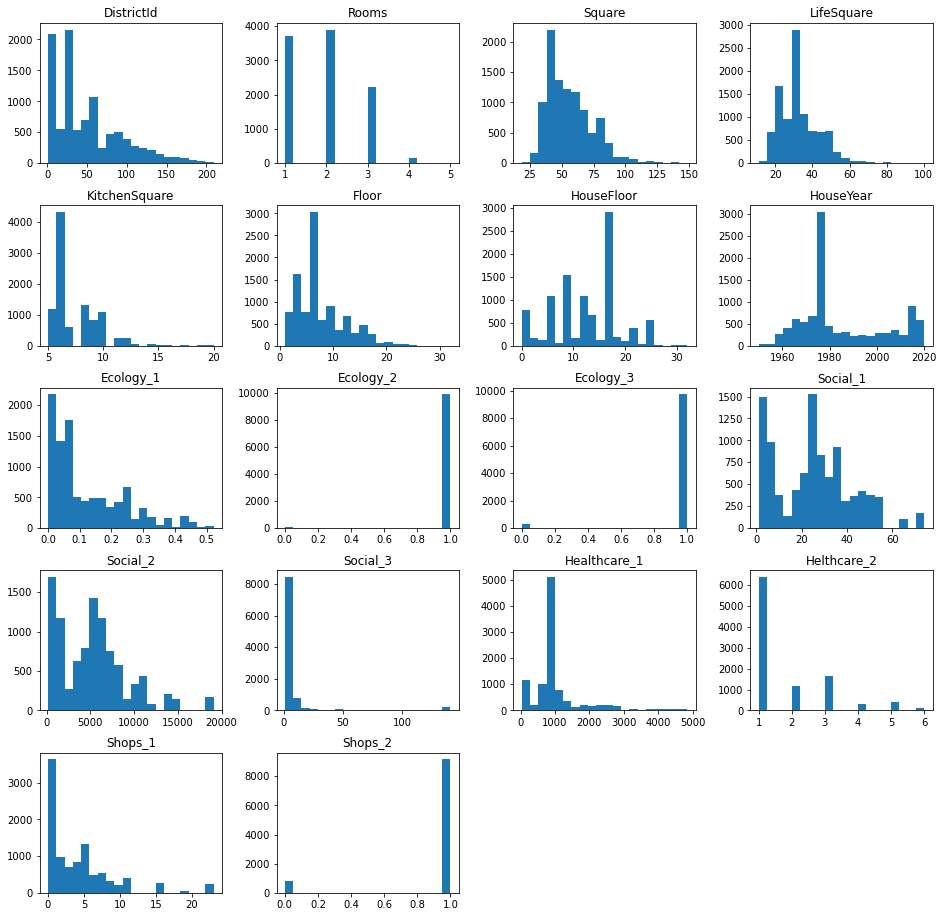

In [34]:
df_numbers_new.hist(figsize=(16,16), bins=20, grid=False)

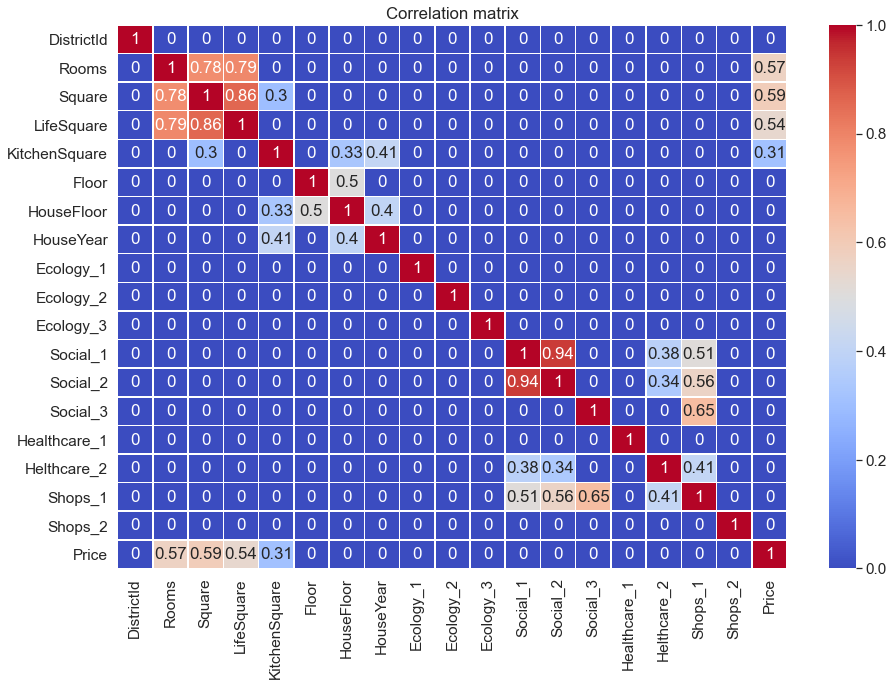

In [35]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.4)
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=0.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [36]:
info_series = df.set_index('Rooms')['Price']
info_series.head(15)

Rooms
3    305018.871089
1    177734.553407
3    282078.720850
1    168106.007630
2    343995.102962
3    161044.944138
1    142402.739272
2    326174.175191
1    160400.401732
3    194756.023945
3    512797.373401
2    253124.005332
1    199556.865905
2    213001.515269
3    481360.360728
Name: Price, dtype: float64

In [37]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  object 
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  int64  
 3   Square         10000 non-null  float64
 4   LifeSquare     10000 non-null  float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  int64  
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  int32  
 11  Ecology_3      10000 non-null  int32  
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   10000 non-null  float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [38]:
df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,50.573600,1.888400,55.956299,33.292591,7.339900,7.821400,12.526600,1985.211200,1.229078e-01,0.990300,0.972500,25.189500,5352.157400,8.638600,1026.448900,1.740900,4.231300,0.917500,214138.857399
std,43.458595,0.811056,18.068612,10.720522,2.149565,4.466083,6.459928,17.805738,1.161603e-01,0.098015,0.163543,17.172387,4006.799803,23.646554,746.593341,1.167263,4.806341,0.275139,92872.293865
min,1.000000,1.000000,18.509177,11.047605,5.000000,1.000000,0.000000,1950.000000,1.800000e-09,0.000000,0.000000,1.000000,168.000000,1.000000,30.000000,1.000000,0.000000,0.000000,59174.778028
25%,21.000000,1.000000,41.807906,24.723435,6.000000,5.000000,9.000000,1974.000000,3.465608e-02,1.000000,1.000000,9.000000,1564.000000,2.000000,830.000000,1.000000,1.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,33.129704,6.000000,7.000000,13.000000,1977.000000,7.542368e-02,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,75.000000,2.000000,65.820977,38.569612,9.000000,10.000000,17.000000,2001.000000,1.957811e-01,1.000000,1.000000,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,1.000000,249135.462171
max,209.000000,5.000000,148.671938,100.201652,20.000000,32.000000,32.000000,2020.000000,5.218671e-01,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


In [39]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [40]:
f_names = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
           'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']
t_name = 'Price'

In [41]:
df = df[f_names + [t_name]]
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3,115.027311,69.016386,10.0,4,10,2014,0.075424,1,1,11,3097,2,900.0,1,0,1,305018.871089
1,3013,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,8215,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,1,1,33,5261,2,240.0,3,1,1,282078.720850
3,2352,1,1,40.409907,24.245944,6.0,10,22,1977,0.007122,1,1,1,264,2,900.0,1,1,1,168106.007630
4,13866,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,1,1,33,8667,2,900.0,1,6,1,343995.102962


In [42]:
#f_names_for_stand = df[f_names].select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
#f_names_for_stand

In [43]:
#scaler = StandardScaler()
#s_features = scaler.fit_transform(df[f_names_for_stand])
#s_features

In [44]:
#df[f_names_for_stand] = pd.DataFrame(s_features, columns=f_names_for_stand)
#df.head()

In [45]:
df.to_csv("PREPARED_DATASET_PATH.csv", index=False, encoding='utf-8', sep=',')

In [46]:
X = df[f_names]
y = df[t_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)
y.head()

0    305018.871089
1    177734.553407
2    282078.720850
3    168106.007630
4    343995.102962
Name: Price, dtype: float64

In [47]:
def evaluate_preds(true_values, pred_values, save=False):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
       "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
       "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
       f"Mean target: {round(np.mean(true_values), 3)}")
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.526
RMSE:	63637.817
MSE:	4049771736.191
Mean target: 213586.882


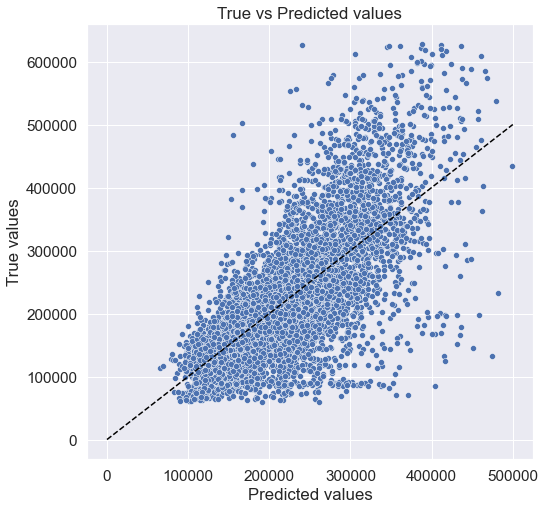

In [48]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_train_preds = lr_model.predict(X_train)
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=800000)
evaluate_preds(y_train, y_train_preds)

Text(0, 0.5, 'Признак')

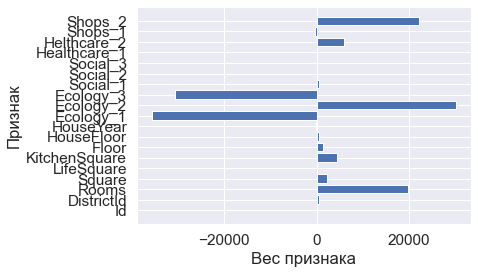

In [49]:
plt.barh(X_train.columns, lr_model.coef_.flatten())
plt.xlabel('Вес признака')
plt.ylabel('Признак')

R2:	0.542
RMSE:	64481.504
MSE:	4157864305.227
Mean target: 217266.717


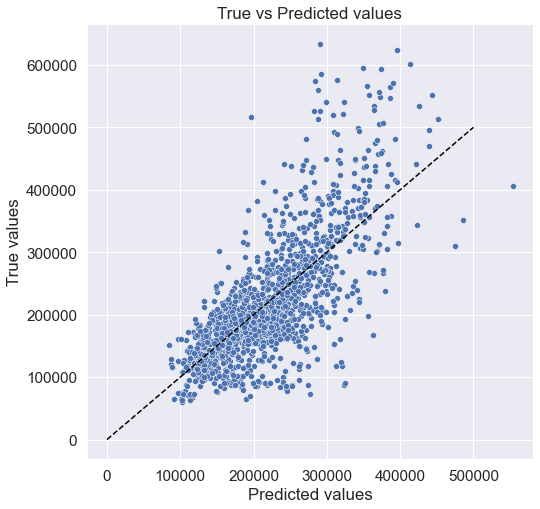

In [50]:
y_test_preds = lr_model.predict(X_test)
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=800000)
evaluate_preds(y_test, y_test_preds)

R2:	0.676
RMSE:	52586.153
MSE:	2765303485.256
Mean target: 213586.882


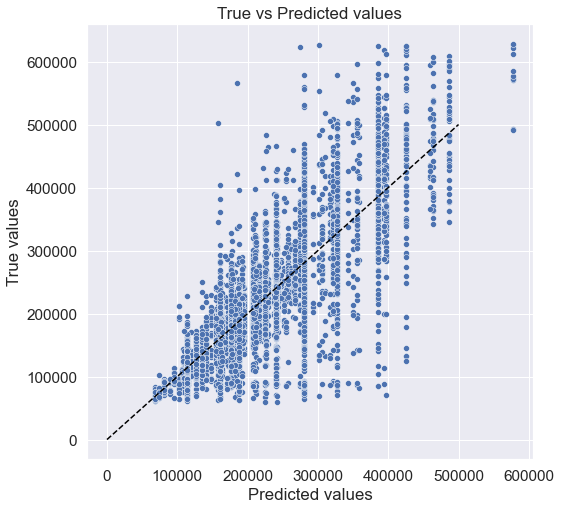

In [51]:
dt_model = DecisionTreeRegressor(criterion='mse',
                                 max_depth=7,
                                 min_samples_leaf=10, 
                                 random_state=42)
dt_model.fit(X_train, y_train)
y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.674
RMSE:	54397.272
MSE:	2959063156.839
Mean target: 217266.717


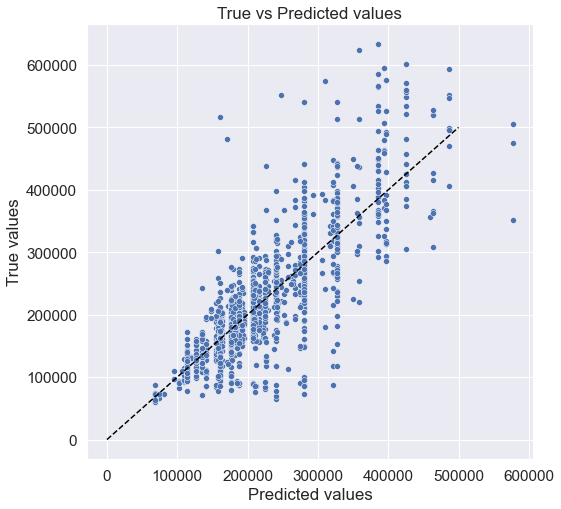

In [52]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

R2:	0.867
RMSE:	33708.711
MSE:	1136277215.124
Mean target: 213586.882


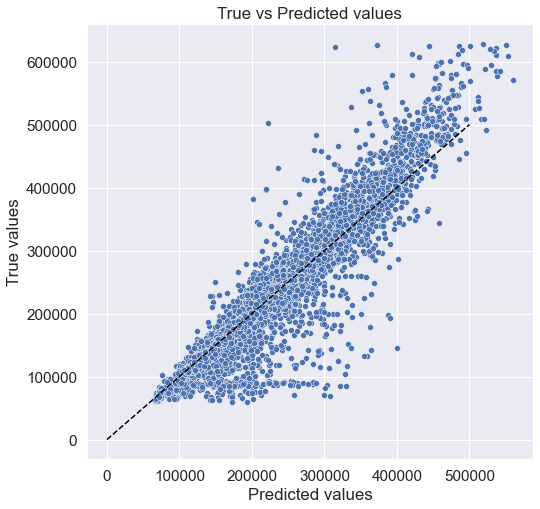

In [53]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20,
                                 min_samples_leaf=5,
                                 random_state=42,
                                 n_estimators=200)
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.73
RMSE:	49534.38
MSE:	2453654768.153
Mean target: 217266.717


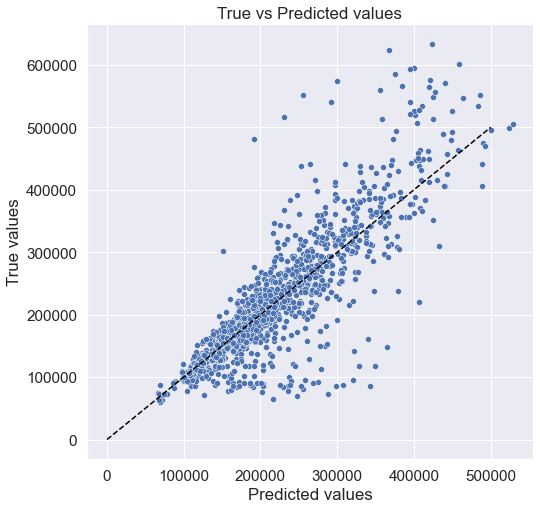

In [54]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [55]:
sum(rf_model.feature_importances_)

1.0

In [56]:
feature_importance = pd.DataFrame({'name':X.columns,
                                  'feature_importance':rf_model.feature_importances_},
                                 columns=['feature_importance', 'name'])
print(feature_importance)

    feature_importance           name
0             0.017309             Id
1             0.041346     DistrictId
2             0.092804          Rooms
3             0.405822         Square
4             0.022030     LifeSquare
5             0.016313  KitchenSquare
6             0.015668          Floor
7             0.016765     HouseFloor
8             0.021905      HouseYear
9             0.036825      Ecology_1
10            0.000097      Ecology_2
11            0.000179      Ecology_3
12            0.017545       Social_1
13            0.192262       Social_2
14            0.057008       Social_3
15            0.021638   Healthcare_1
16            0.005097    Helthcare_2
17            0.018990        Shops_1
18            0.000399        Shops_2


R2:	0.854
RMSE:	35290.09
MSE:	1245390476.976
Mean target: 213586.882


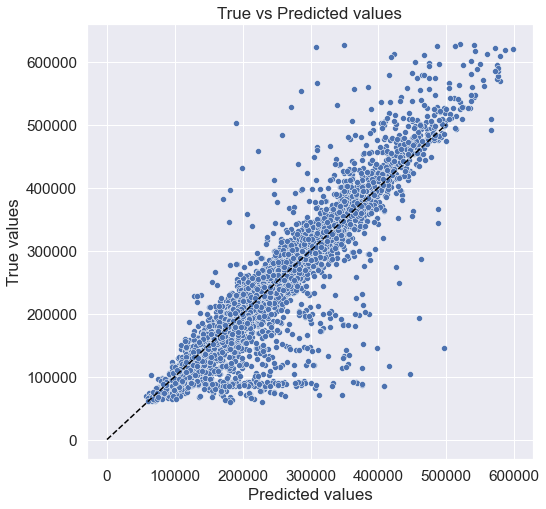

In [57]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=2250, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
gb_model.fit(X_train, y_train)
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.77
RMSE:	45680.053
MSE:	2086667212.315
Mean target: 217266.717


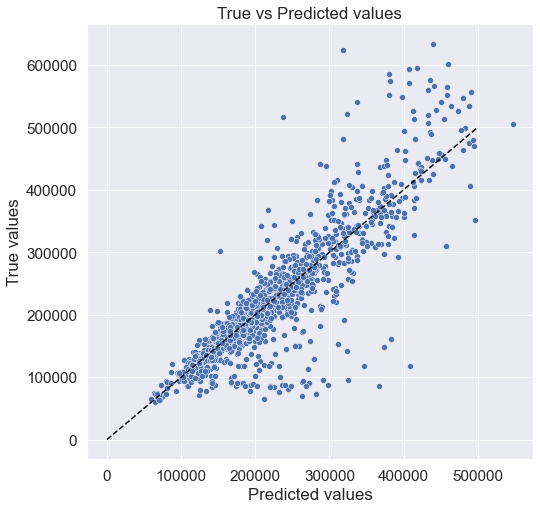

In [58]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [59]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(gb_model, file)

In [60]:
#with open(SCALER_FILE_PATH, 'wb') as file:
   # pickle.dump(scaler, file)

In [61]:
with open(MODEL_FILE_PATH, 'rb') as file:
    gb_model = pickle.load(file)
gb_model

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=6, max_features='sqrt', min_samples_leaf=50,
                          n_estimators=2250, random_state=42)